In [47]:
%pip install matplotlib
%pip install pandas
%pip install pint

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import pint

In [52]:
ureg = pint.UnitRegistry()

In [66]:
def make_line_better(json):
    if "cpu_atom" in json["event"]:
        return None
    if "instructions" in json["event"]:
        return ("instructions", float(json["counter-value"]), float(json["variance"]))
    if "cycles" in json["event"]:
        return ("cycles", float(json["counter-value"]), float(json["variance"]))
    if "task-clock" in json["event"]:
        t = ureg(json["counter-value"] + " " + json["unit"]).to(ureg("s")).magnitude
        factor = ureg("1 " + json["unit"]).to(ureg("s")).magnitude
        var = float(json["variance"]) * factor * factor
        return ("time", t, var)
    print("Unhandled event: " + json["event"])
    return None

In [80]:
# read the data
def read_qemu_patched(values):
    filenames = map(lambda x: (x, f"qemu_patched_{x}.json"), values)
    vals = []
    for (nbnops, filename) in filenames:
        with open(filename, 'r') as f:
            temp = []
            for line in f:
                line = json.loads(line)
                line = make_line_better(line)
                if line is not None:
                    temp.append(line)
            
            temp.sort(key=lambda x: x[0])
            temp = [item for tup in temp for item in tup[1:]]
            vals.append(temp)
    return (values, vals)

In [91]:
(indices, patched_data) = read_qemu_patched(range(0, 10000, 1000))
patched_data = pd.DataFrame(patched_data, index=indices, columns=["instructions", "instr_var", "cycles", "cycles_var", "time", "time_var"])
patched_data

,instructions,instr_var,cycles,cycles_var,time,time_var
0,4665088.0,0.04,7944357.0,0.0,0.002909,8.000000e-08
1000,4929600.0,0.04,8865832.0,0.0,0.002973,7.000000e-08
2000,5208047.0,0.04,9804277.0,0.0,0.003048,7.000000e-08
3000,5454115.0,0.04,10742969.0,0.0,0.003094,7.000000e-08
4000,5728549.0,0.05,11681793.0,0.0,0.003152,9.000000e-08
5000,5968116.0,0.04,12623151.0,0.0,0.003199,7.000000e-08
6000,6216037.0,0.04,13562067.0,0.0,0.003248,7.000000e-08
7000,6461583.0,0.03,14500977.0,0.0,0.003296,7.000000e-08
8000,6734549.0,0.04,15439907.0,0.0,0.003369,7.000000e-08
9000,6972600.0,0.03,16381100.0,0.0,0.003405,7.000000e-08


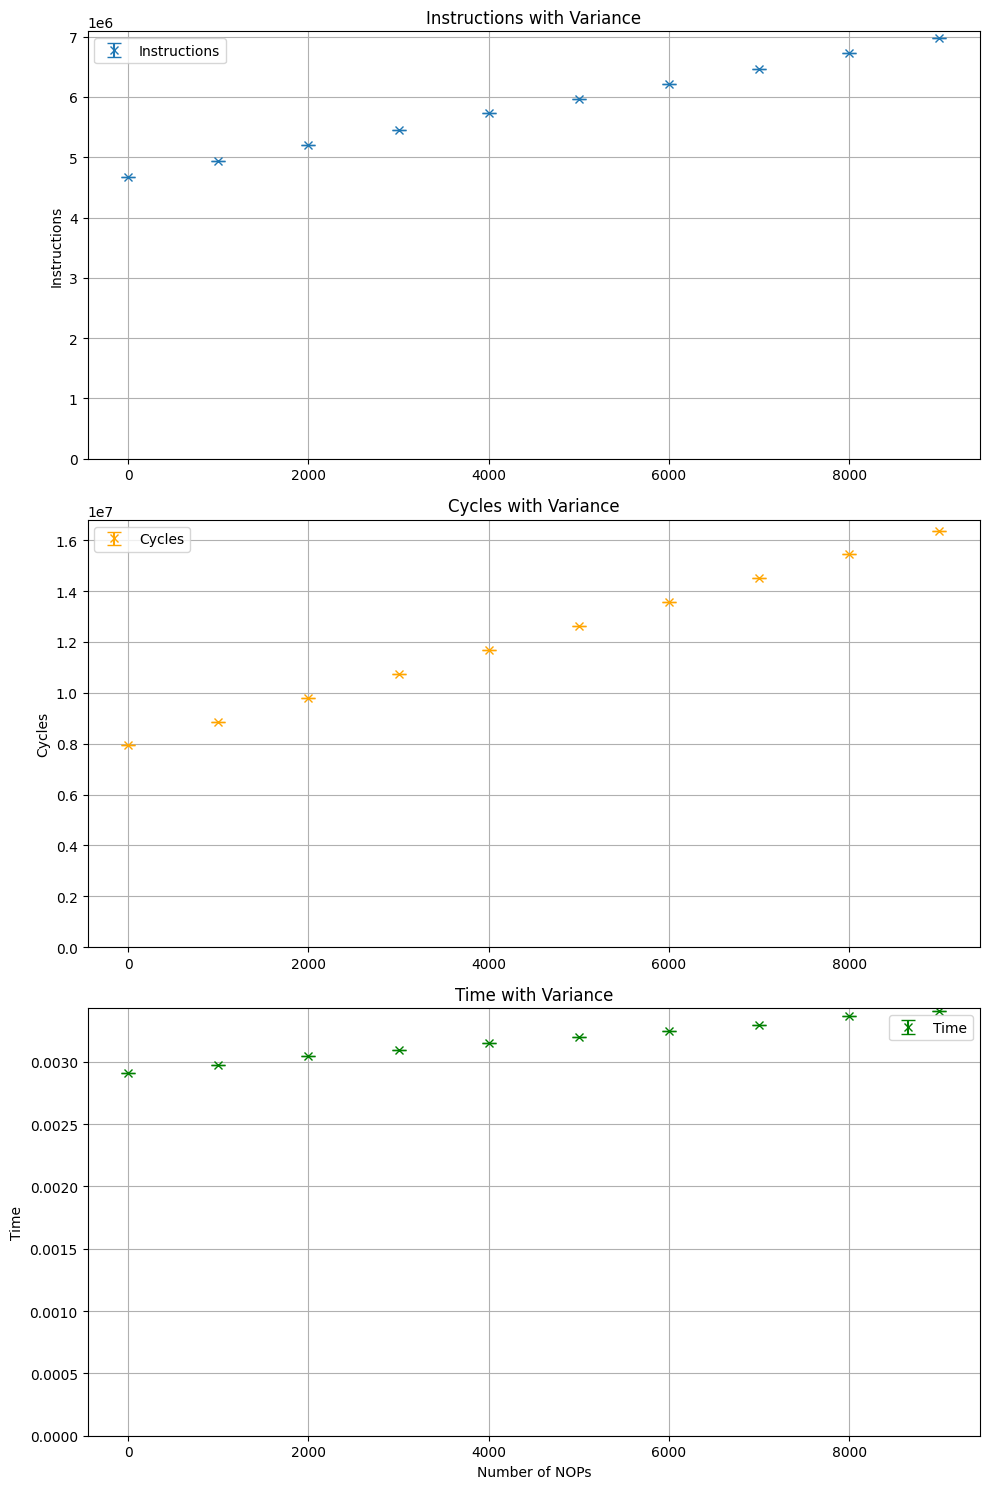

In [90]:
df = patched_data
# thanks chatgpt
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot "instructions" with variance
axs[0].errorbar(df.index, df['instructions'], yerr=df['instr_var'], fmt='x', label='Instructions', capsize=5)
axs[0].set_ylabel('Instructions')
axs[0].set_title('Instructions with Variance')
axs[0].legend()
axs[0].set_ylim(bottom=0)
axs[0].grid()

# Plot "cycles" with variance
axs[1].errorbar(df.index, df['cycles'], yerr=df['cycles_var'], fmt='x', label='Cycles', capsize=5, color='orange')
axs[1].set_ylabel('Cycles')
axs[1].set_title('Cycles with Variance')
axs[1].set_ylim(bottom=0)
axs[1].legend()
axs[1].grid()

# Plot "time" with variance
axs[2].errorbar(df.index, df['time'], yerr=df['time_var'], fmt='x', label='Time', capsize=5, color='green')
axs[2].set_ylabel('Time')
axs[2].set_title('Time with Variance')
axs[2].legend()
axs[2].grid()
axs[2].set_ylim(bottom=0)

axs[2].set_xlabel("Number of NOPs")

plt.tight_layout()
plt.show()